In [1]:
import neuromancer.psl as psl
from neuromancer.dynamics import ode
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp

from tqdm.auto import tqdm
plt.style.use('ggplot')

/Users/Malachite/Documents/github/stable_node_control/.venv311/lib/python3.11/site-packages/mlflow/utils/requirements_utils.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


**System model**:  
The system dynamics is defined by following nonlinear ordinary differential equations (ODEs):
$$
 \frac{dx_1}{dt} = c_1 (1.0 - v)  p - c_2  \sqrt{x_1}  \\  
 \frac{dx_2}{dt}  = c_1 v p + c_2  \sqrt{x_1} - c_2 \sqrt{x_2}
$$  
With system states $x_1$, and $x_2$ representing liquid levels in tank 1 and 2, respectively. Control actions are pump modulation $p$, and valve opening $v$. The ODE system is parametrized by inlet and outlet valve coefficients $c_1$ and $c_2$, respectively.

In [2]:
gt_model = psl.nonautonomous.TwoTank()

In [3]:
variables, constants, parameters, _ = gt_model.params

In [4]:
x0 = variables['x0']
ts = constants['ts']
c1,c2 = parameters["c1"], parameters["c2"]

In [14]:
two_tank_ode_nm = ode.TwoTankParam()
two_tank_ode_nm.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank_ode_nm.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)



def two_tank_ode(t,x,u):
    with torch.no_grad():
        dh =  two_tank_ode_nm.ode_equations(
            torch.tensor([x]),
            torch.tensor([u])
        )
        return dh.squeeze().numpy()

In [21]:
x0 = [0.5,0.5]
u=[1,0.2]
two_tank_ode(0,x0,u)

array([0.03571573, 0.016     ], dtype=float32)

In [22]:
t_max= 300

sol = solve_ivp(
    two_tank_ode,
    t_span=[0,t_max],
    y0 = x0,
    t_eval=np.linspace(0,t_max,501),
    args=(u,)
)

(0.0, 8.14935837412893)

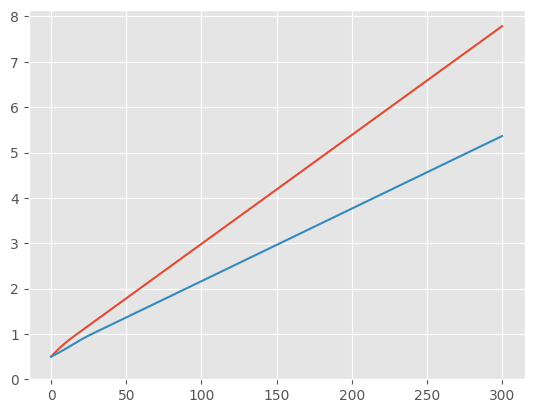

In [24]:
plt.plot(sol.t,sol.y[0,:])
plt.plot(sol.t,sol.y[1,:])
plt.ylim(0,)

In [ ]:
def two_tank_ode(t, x, u, c):
    x1, x2 = x
    p, v = u
    c1, c2 = c

    # Clip controls
    pump = np.clip(p, 0.0, 1.0)
    valve = np.clip(v, 0.0, 1.0)

    # Base derivatives (before enforcing bounds)
    dhdt1 = c1*(1.0 - valve)*pump - c2*np.sqrt(max(x1, 0.0))
    dhdt2 = c1*valve*pump + c2*np.sqrt(max(x1, 0.0)) - c2*np.sqrt(max(x2, 0.0))

    # Enforce boundaries: prevent leaving [0,1]
    if x1 <= 0.0 and dhdt1 < 0.0:
        dhdt1 = 0.0
    if x1 >= 1.0 and dhdt1 > 0.0:
        dhdt1 = 0.0

    if x2 <= 0.0 and dhdt2 < 0.0:
        dhdt2 = 0.0
    if x2 >= 1.0 and dhdt2 > 0.0:
        dhdt2 = 0.0

    return np.array([dhdt1, dhdt2])


In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
x0 = np.array(x0)

In [ ]:
x0

array([0.5, 0.5])

In [ ]:
t_max = 300
x0 = [0.5,0.5]
u = np.array([0.3,0.])
c = np.array([c1,c2])
sol = solve_ivp(
    two_tank_ode,
    t_span = [0,t_max],
    y0 = np.array(x0),
    t_eval= np.linspace(0,t_max, 501),
    args =(u,c,)
)

In [ ]:
t = sol.t
X = sol.y

In [ ]:
X.shape

(2, 10)

(0.0, 1.0)

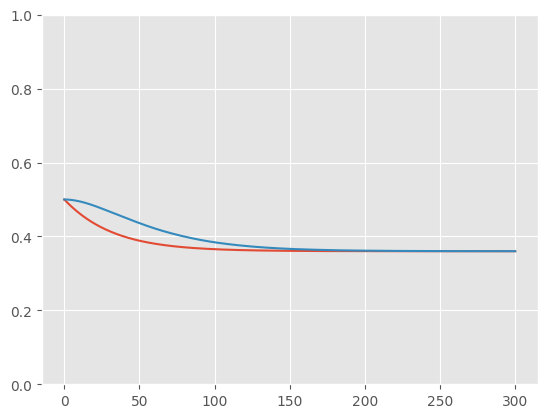

In [ ]:
plt.plot(t, X[0,:])
plt.plot(t,X[1,:])
plt.ylim(0,1)

In [ ]:
p_vals = np.linspace(0,1,101)
v_vals = np.linspace(0,1,101)


X1s = np.zeros((len(p_vals),len(v_vals)))
X2s = np.zeros((len(p_vals),len(v_vals)))

for i, pi in enumerate(tqdm(p_vals)):
    for j, vi in enumerate(v_vals):
        t_max = 300
        x0 = [0.5,0.5]
        u = np.array([pi,vi])
        c = np.array([c1,c2])
        sol = solve_ivp(
            two_tank_ode,
            t_span = [0,t_max],
            y0 = np.array(x0),
            t_eval= np.linspace(0,t_max, 501),
            args =(u,c,)
        )
        x1, x2 = sol.y[:,-1]
        X1s[i,j] = x1
        X2s[i,j] = x2

        


  0%|          | 0/101 [00:00<?, ?it/s]

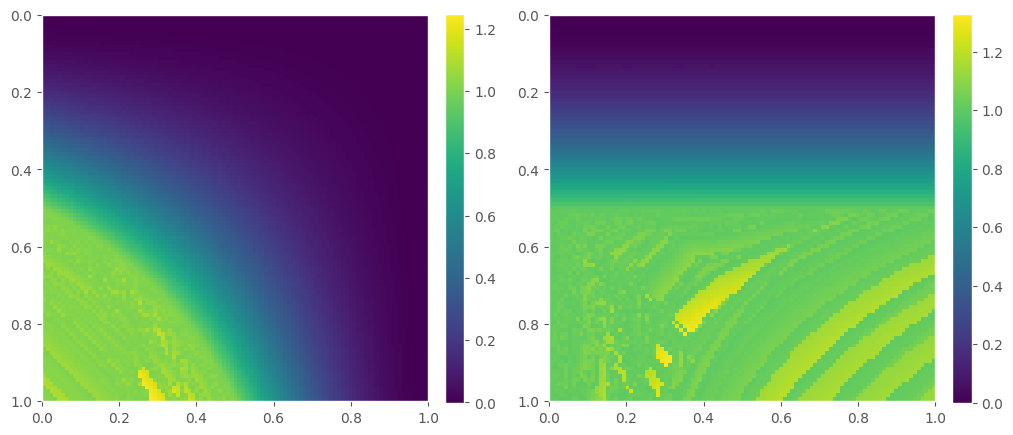

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
im1 = ax1.imshow(X1s,extent=[v_vals[0],v_vals[-1],p_vals[-1],p_vals[0]],)
cbar1 = fig.colorbar(im1,ax=ax1,fraction=0.046,pad=0.04)
ax1.grid(False)

im2 = ax2.imshow(X2s,extent=[v_vals[0],v_vals[-1],p_vals[-1],p_vals[0]])
cbar1 = fig.colorbar(im2,ax=ax2,fraction=0.046,pad=0.04)
ax2.grid(False)

In [ ]:
X1s[100,0]

1.0282043398740095

In [ ]:
pi = p_vals[100]
vi = v_vals[20]
pi,vi

(1.0, 0.2)

In [ ]:

t_max = 300
x0 = [0.5,0.5]
u = np.array([pi,vi])
c = np.array([c1,c2])
sol = solve_ivp(
    two_tank_ode,
    t_span = [0,t_max],
    y0 = np.array(x0),
    t_eval= np.linspace(0,t_max, 501),
    args =(u,c,)
)

In [ ]:
t = sol.t
x1, x2 = sol.y

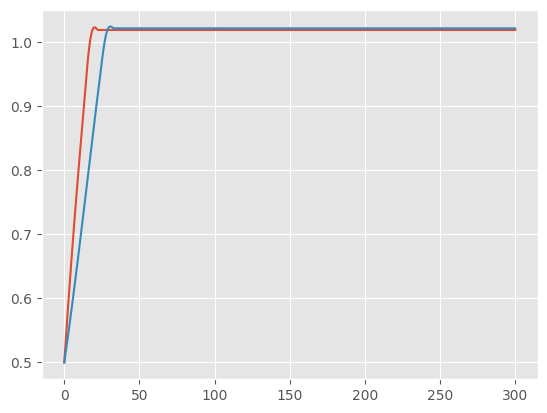

In [ ]:
plt.plot(t,x1)
plt.plot(t,x2)